In [82]:
from helpers import laplace, divergence, gradient, ImageFitting
from siren import Siren

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

import pennylane as qml
from pennylane import numpy as np

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import skimage
import matplotlib.pyplot as plt

import time

In [83]:
sidelength=14

In [84]:
cameraman = ImageFitting(sidelength)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=64,
                  hidden_layers=3, outermost_linear=True)

In [85]:
dev = qml.device("default.qubit", wires=2, shots=None)

@qml.batch_input(argnum=1)
@qml.qnode(dev, diff_method="parameter-shift", interface="torch")
def circuit(inputs, weights):
    qml.RY(weights[0][0], wires=0)
    qml.AngleEmbedding(inputs, wires=range(2), rotation="Y")
    qml.RY(weights[1][1], wires=1)
    return qml.expval(qml.PauliZ(1))

x = torch.rand(size=(10, 2))
w = torch.rand(size=(4, 5,))

circuit(x, w)

tensor([0.2165, 0.4307, 0.5111, 0.3398, 0.7422, 0.3173, 0.4008, 0.3967, 0.1412,
        0.8785], dtype=torch.float64)

In [86]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 5

n_qubits = 5
n_gates_per_layer = 3
n_layer = 10


In [87]:
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

@qml.qnode(dev, interface="torch")
def circuit(params, coord):
    for l, l_params in enumerate(params):
        qml.RY(coord[0], wires=0)
        qml.RY(coord[1], wires=1)
        qml.RY(coord[0], wires=2)
        qml.RY(coord[1], wires=3)

        for q, l_q_params in enumerate(l_params):

            qml.RX(l_q_params[0], wires=q)
            qml.RZ(l_q_params[1], wires=q)

            qml.CRX(l_q_params[2], wires=[q, (q+1)%params.shape[1]])

    return [qml.expval(qml.PauliZ(i)) for i in range(params.shape[1])]

def cost(coords, params):

    out = torch.zeros(size=[coords.shape[0],])
    for i, coord in enumerate(coords):
        # out[i] = torch.mean(torch.stack(circuit(params, coord)), axis=0)
        out[i] = circuit(params, coord)[-1]

    return out

params = torch.rand(size=(n_layer,n_qubits,n_gates_per_layer), requires_grad=True)

In [88]:
# print(qml.draw(circuit, expansion_strategy="device")(x, params))

In [89]:
model_input, ground_truth = next(iter(dataloader))

# scale the model input between 0..pi
model_input[0] = (torch.asin(model_input[0])+torch.pi/2)/2

# scale the data between -1..1 (yeah, I know that's ugly)
ground_truth = 2/(torch.abs(ground_truth.max() - ground_truth.min())) * (-ground_truth.min() + ground_truth) - 1

print(f"Model Input: Min: {model_input[0].min()}, Max: {model_input[0].max()}")

print(f"Ground Truth: Min: {ground_truth[0].min()}, Max: {ground_truth[0].max()}")


Model Input: Min: 0.0, Max: 1.5707963705062866
Ground Truth: Min: -1.0, Max: 0.9999998807907104


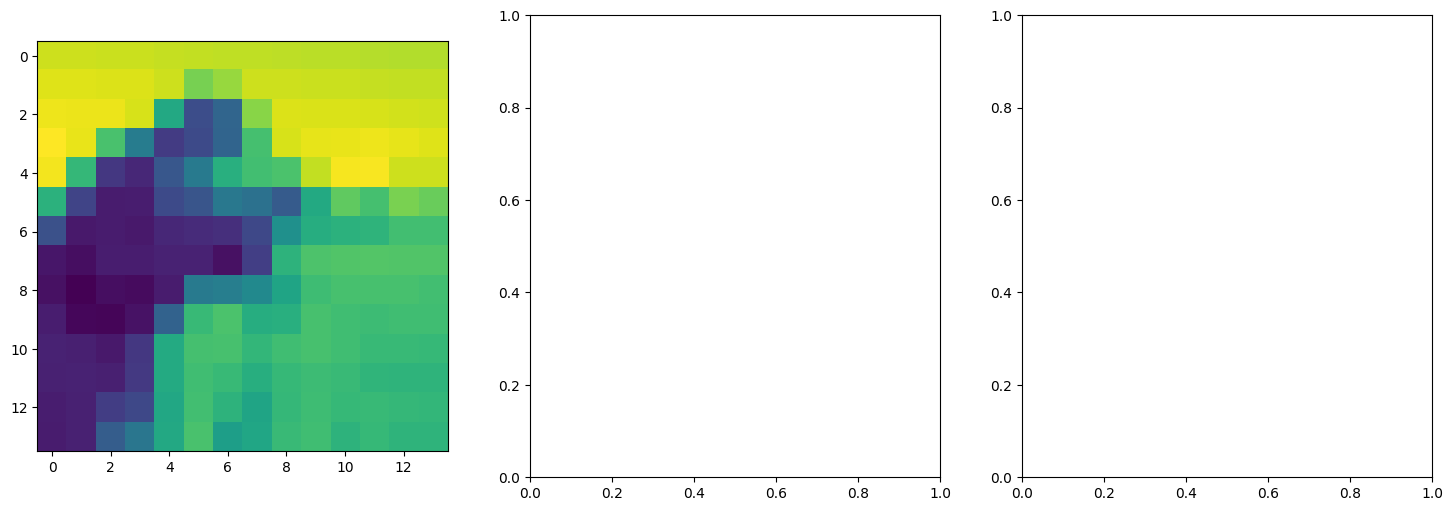

Step 0, Total loss 0.535989


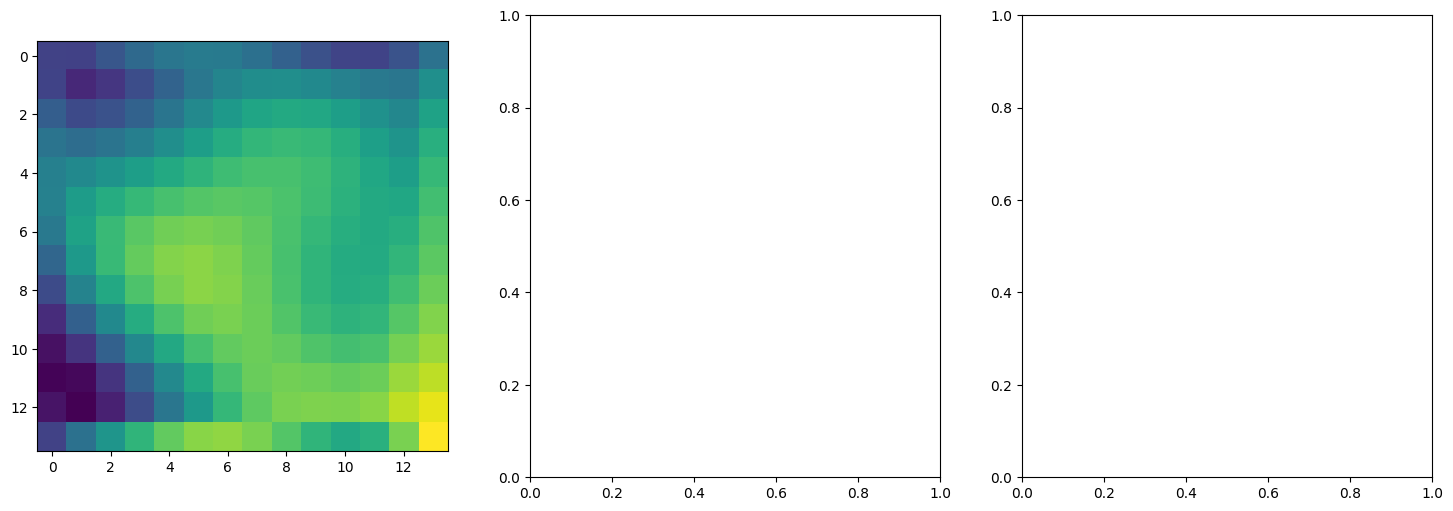

Step 5, Total loss 0.334273


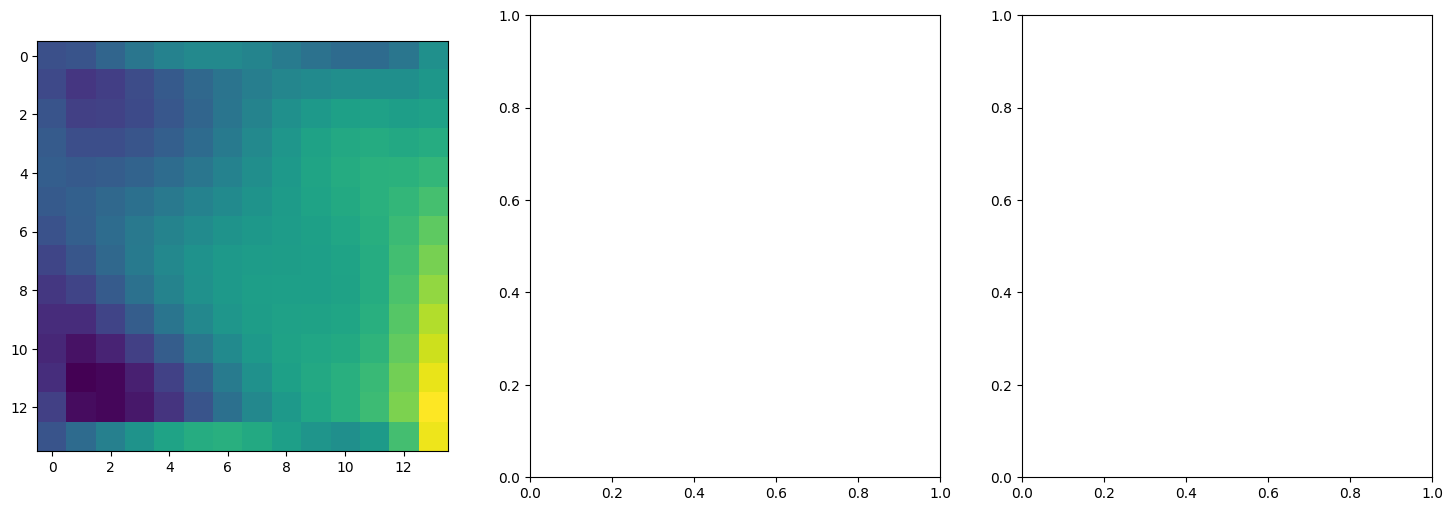

Step 10, Total loss 0.296134


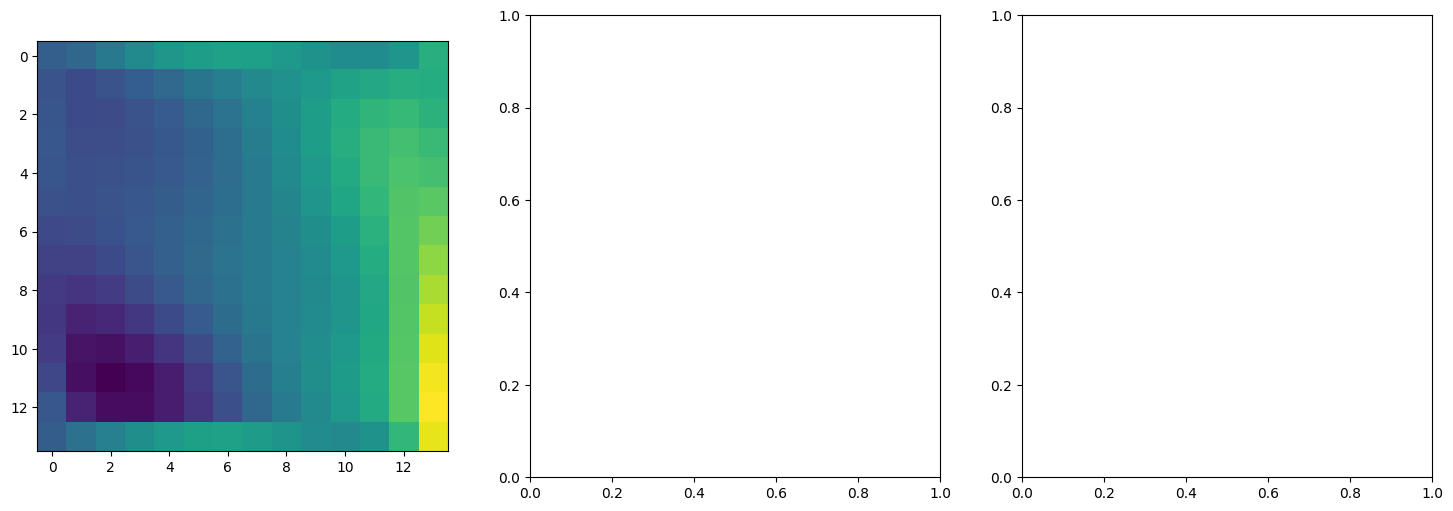

Step 15, Total loss 0.253071


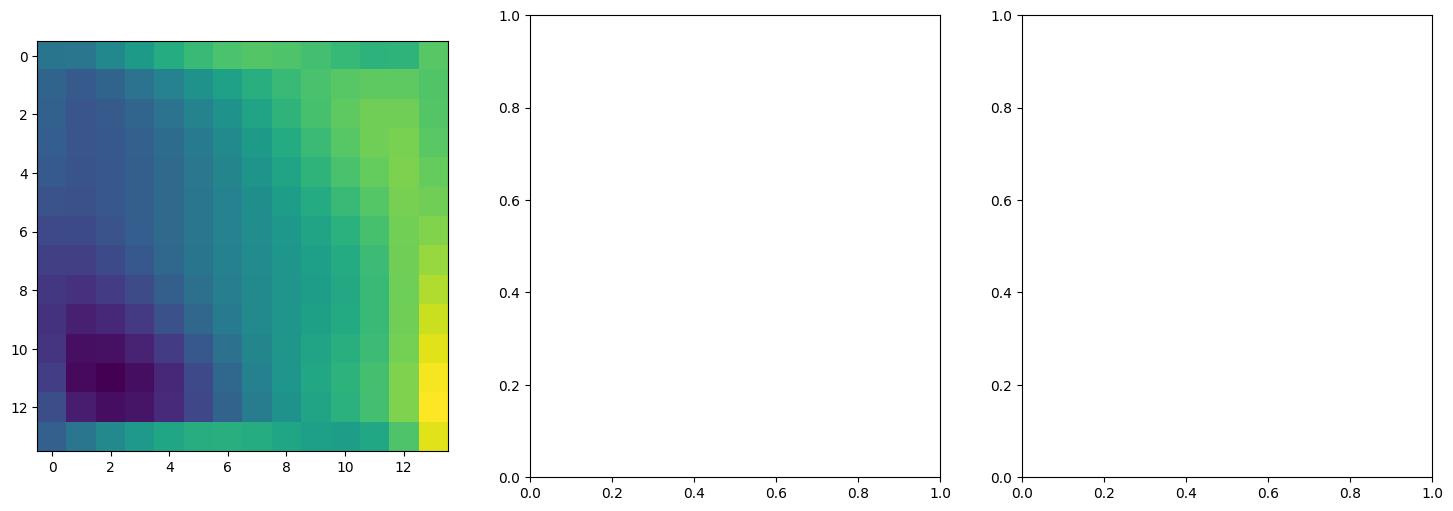

Step 20, Total loss 0.226088


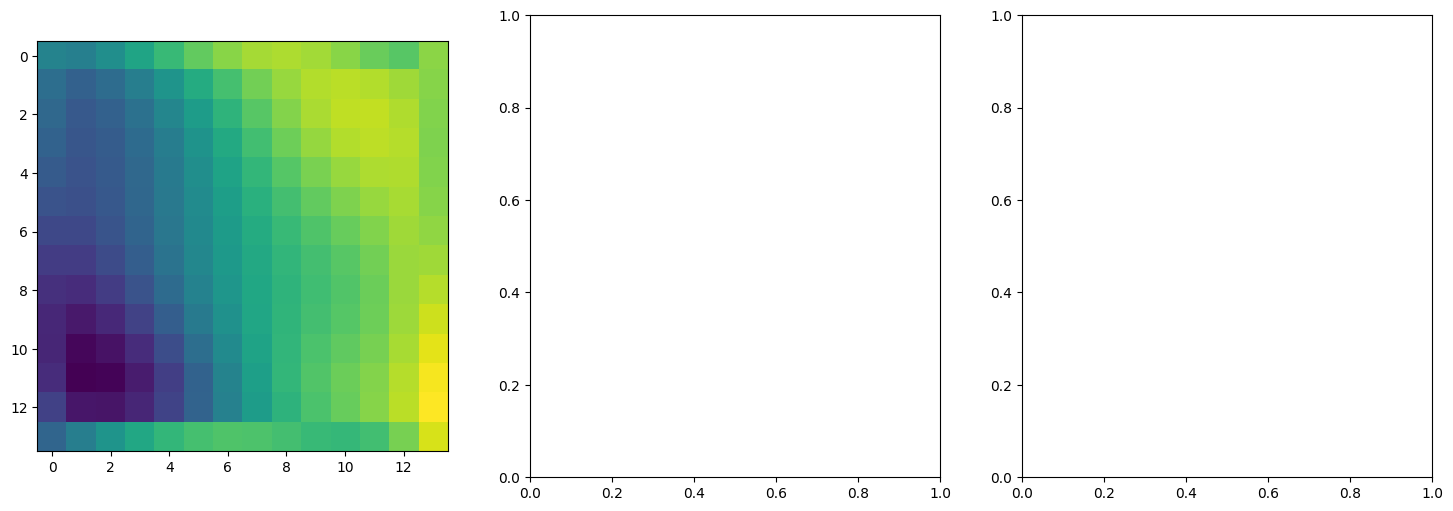

Step 25, Total loss 0.213524


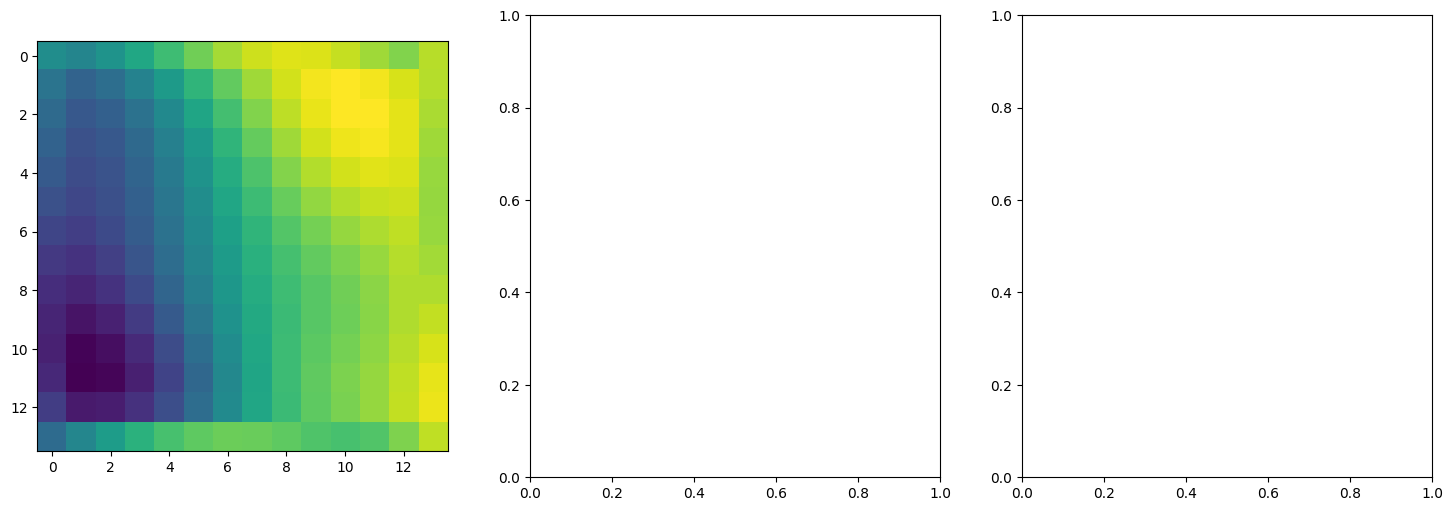

Step 30, Total loss 0.198207


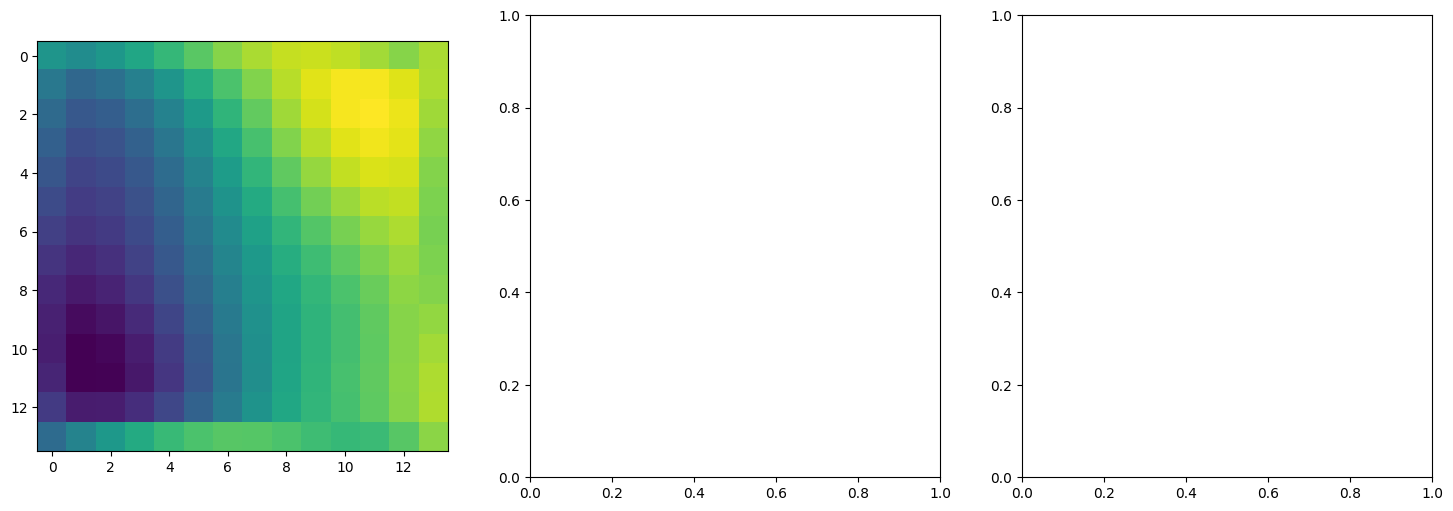

Step 35, Total loss 0.187874


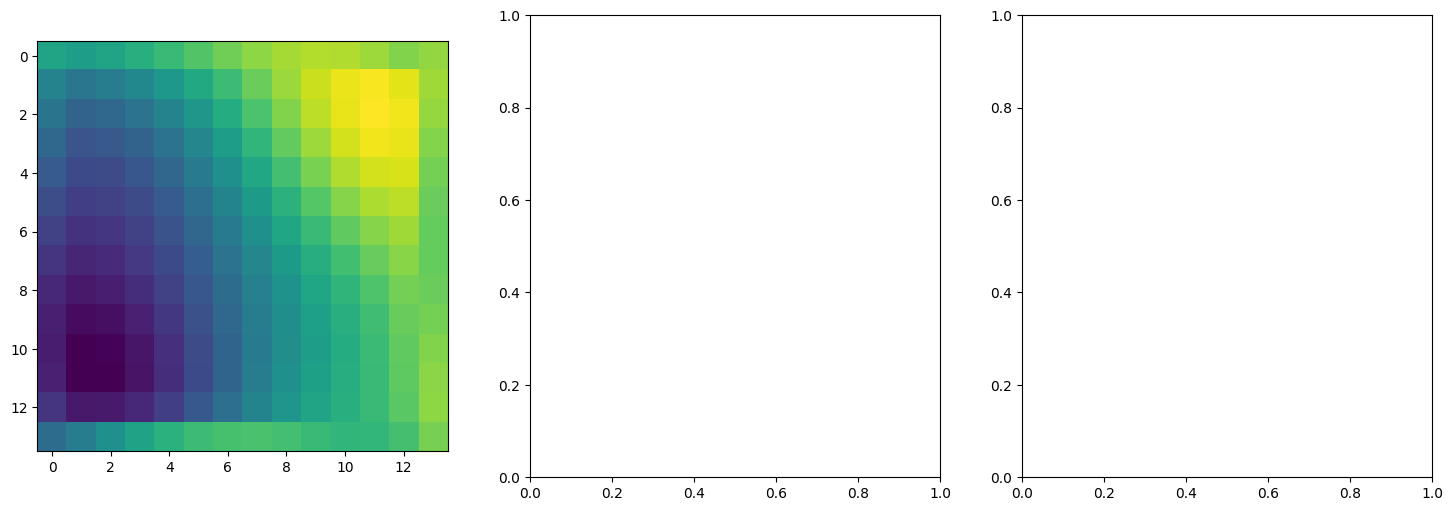

Step 40, Total loss 0.178344


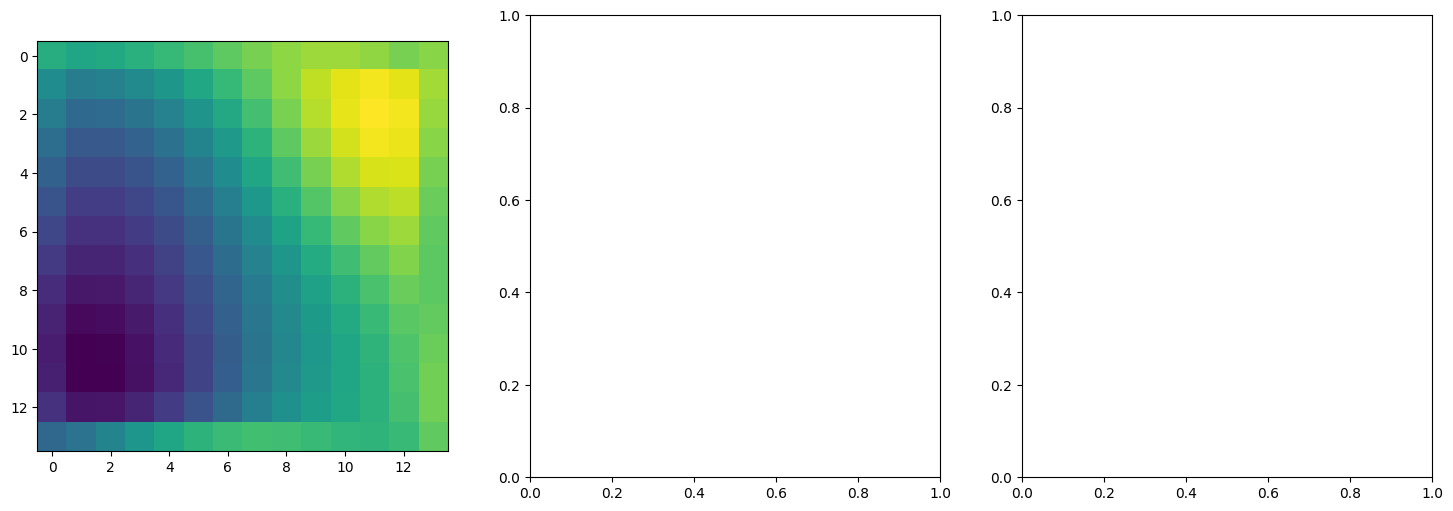

Step 45, Total loss 0.167424


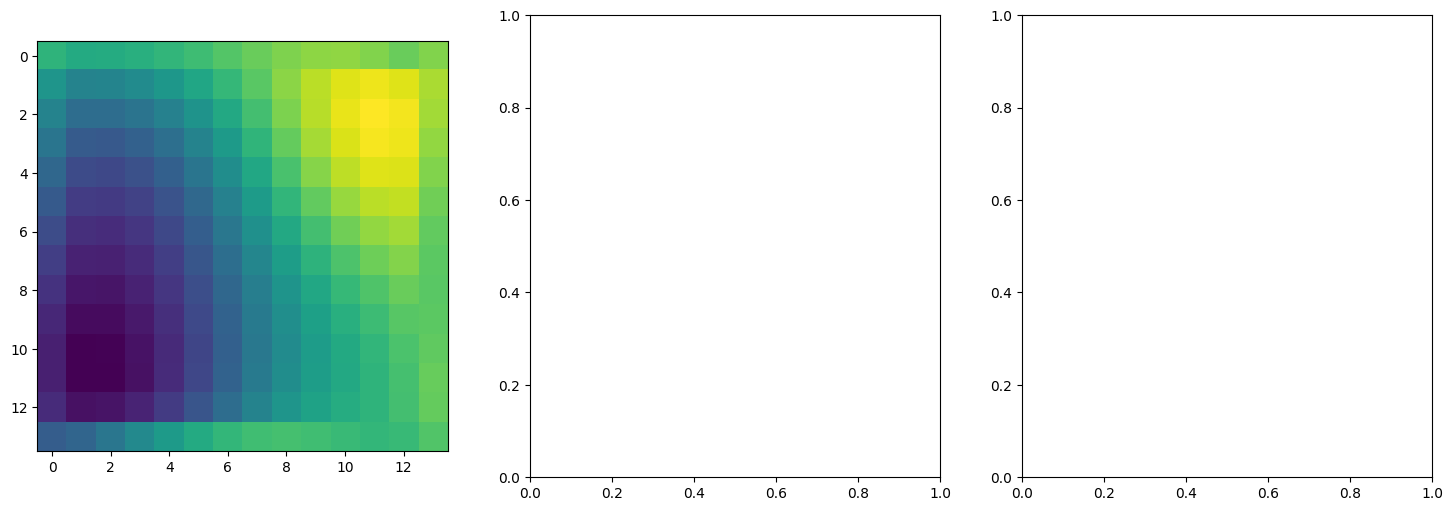

Step 50, Total loss 0.156881


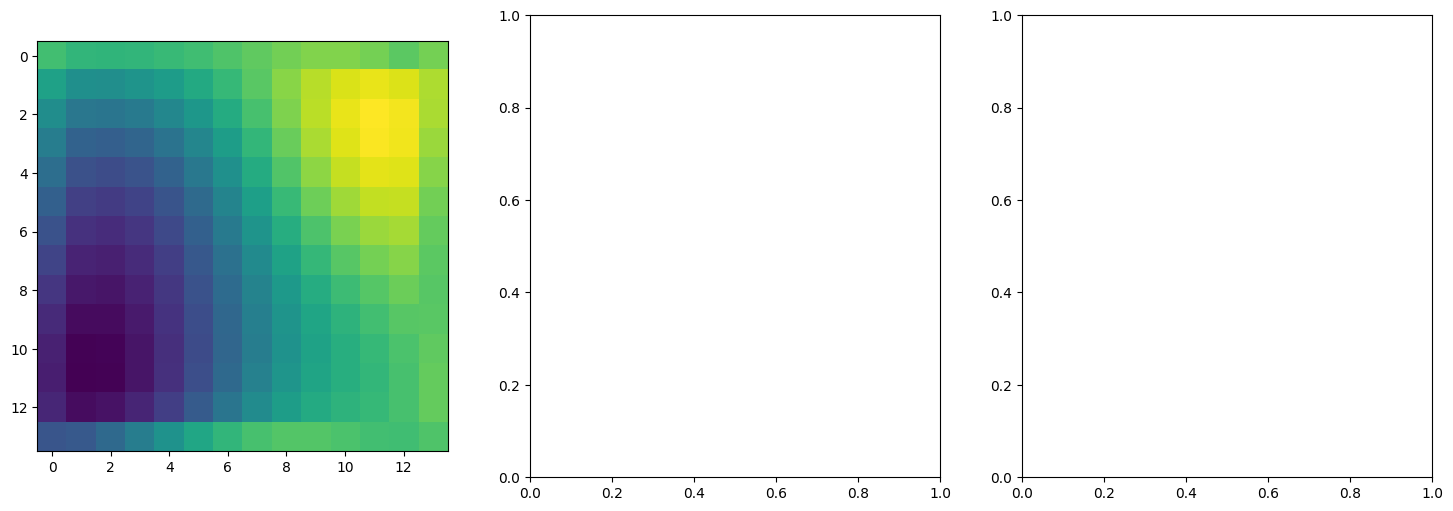

Step 55, Total loss 0.145791


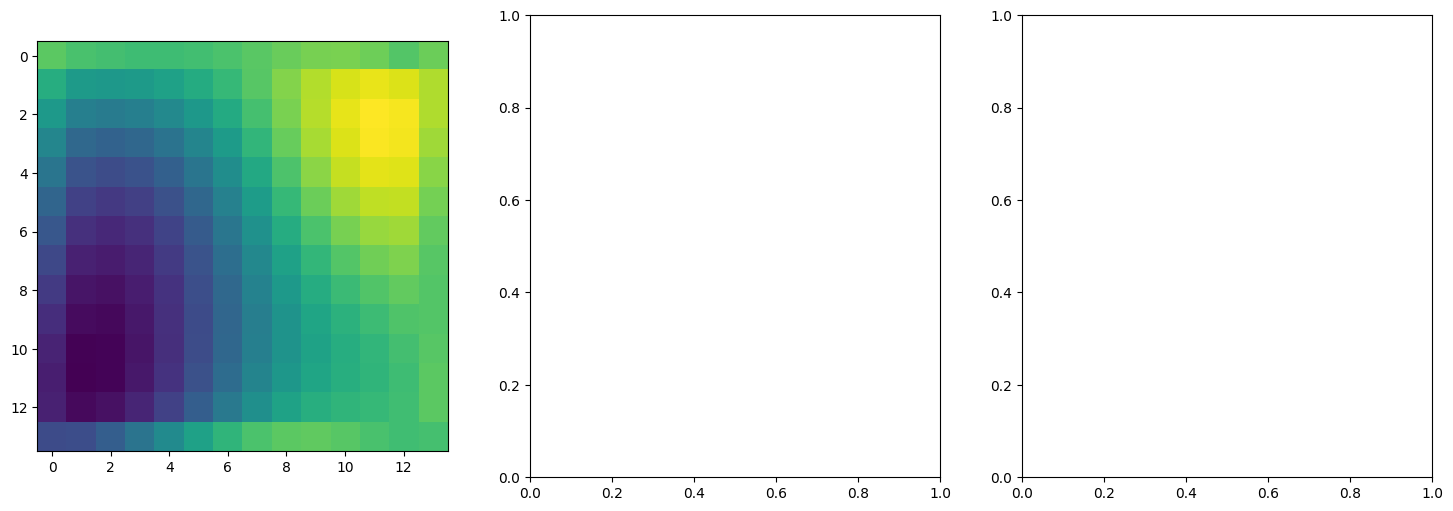

Step 60, Total loss 0.134613


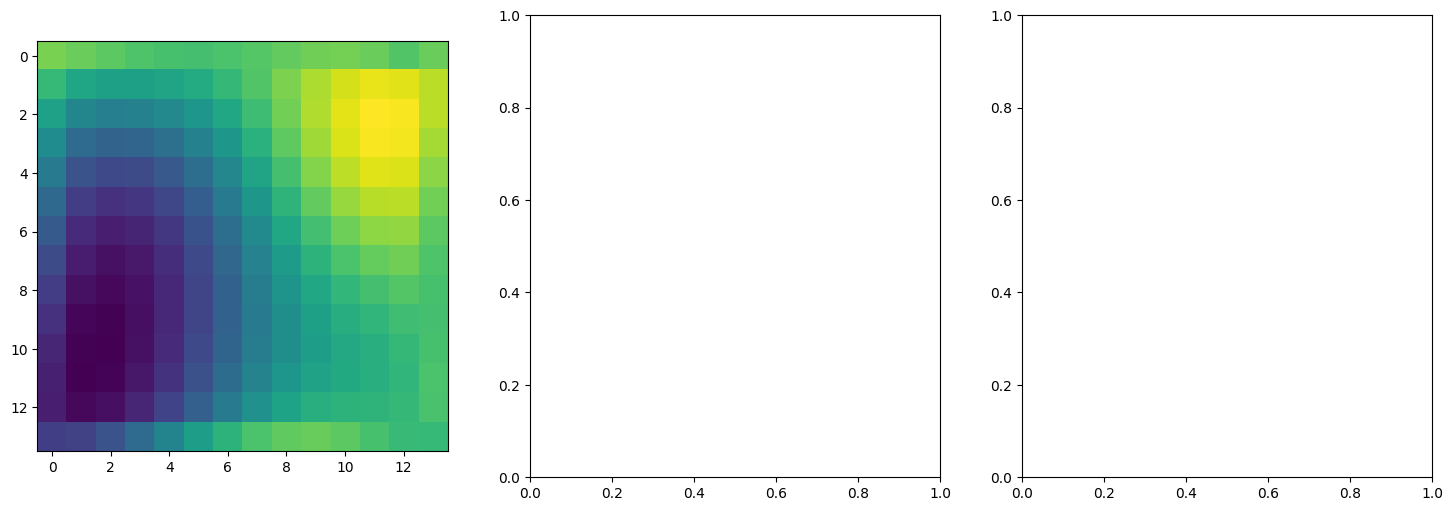

Step 65, Total loss 0.124606


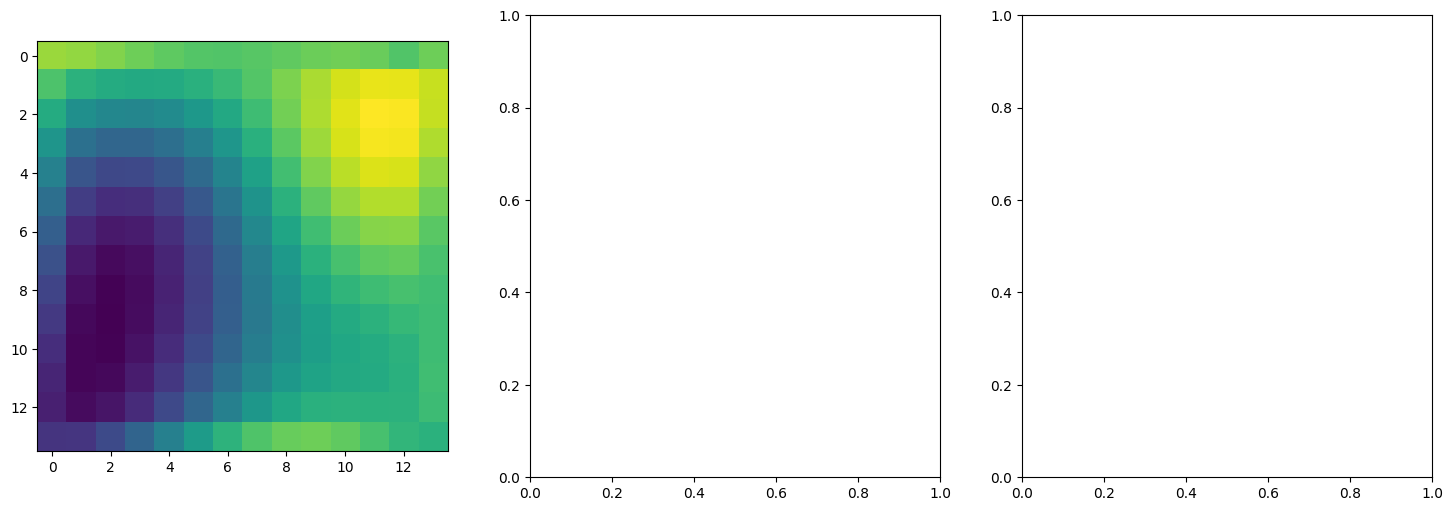

Step 70, Total loss 0.116310


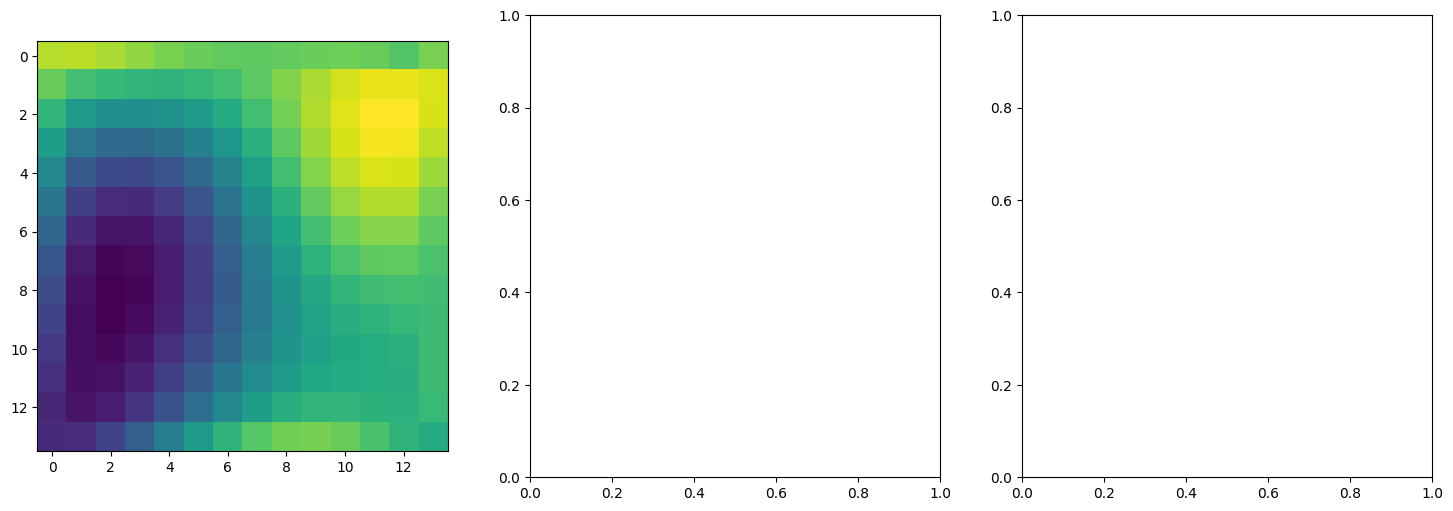

Step 75, Total loss 0.109833


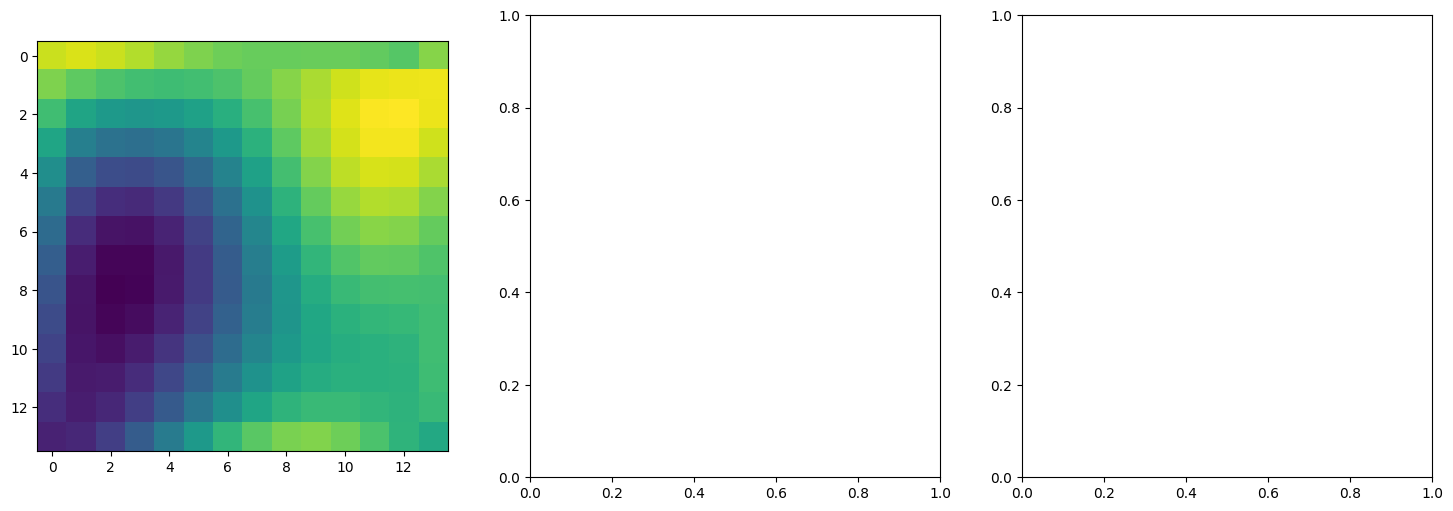

Step 80, Total loss 0.104718


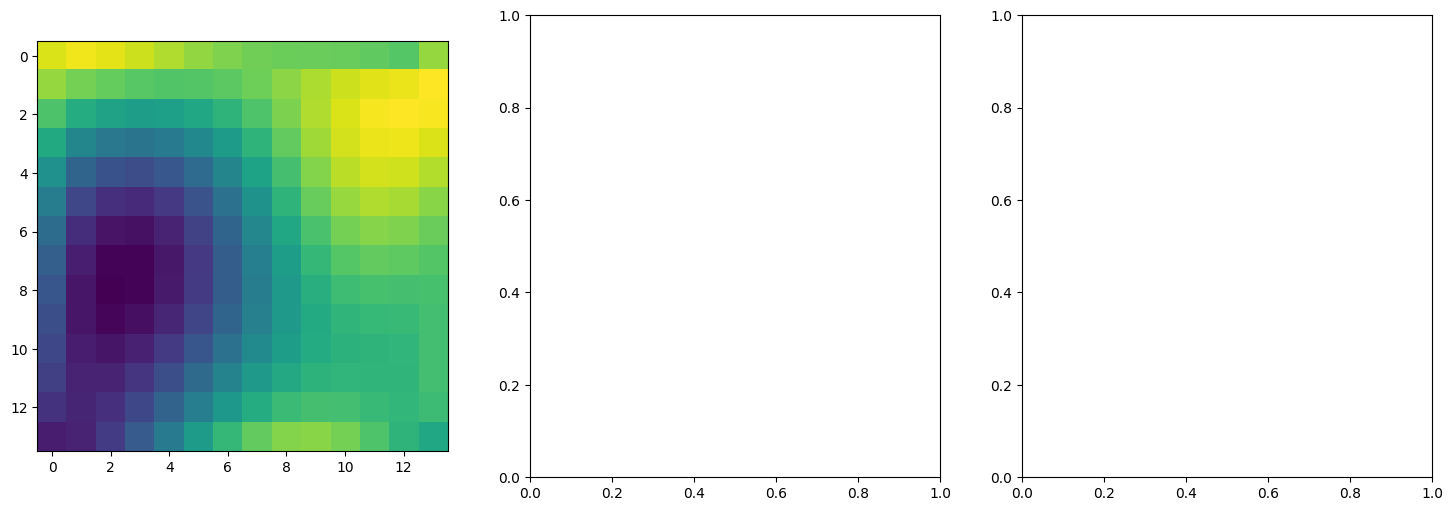

Step 85, Total loss 0.100294


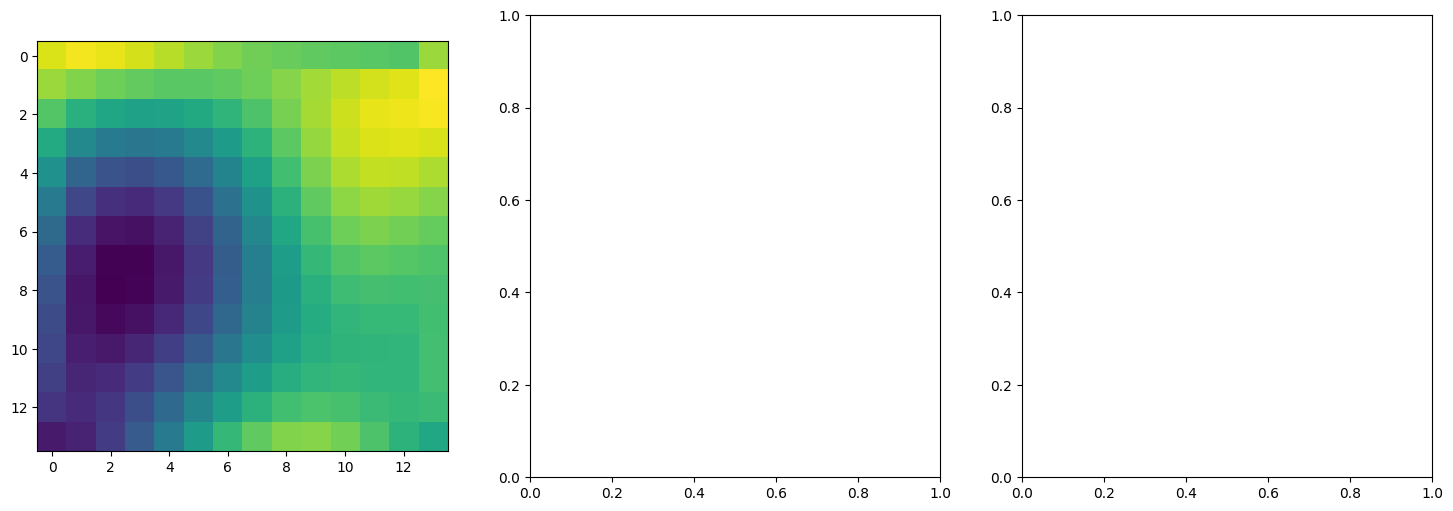

Step 90, Total loss 0.096220


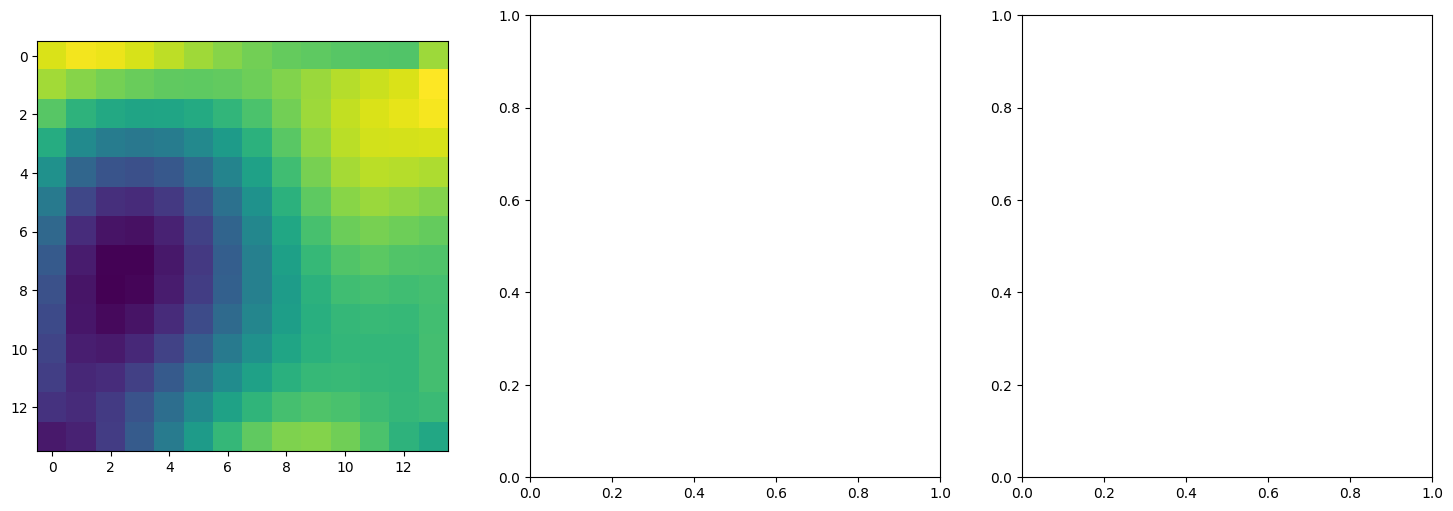

Step 95, Total loss 0.092436


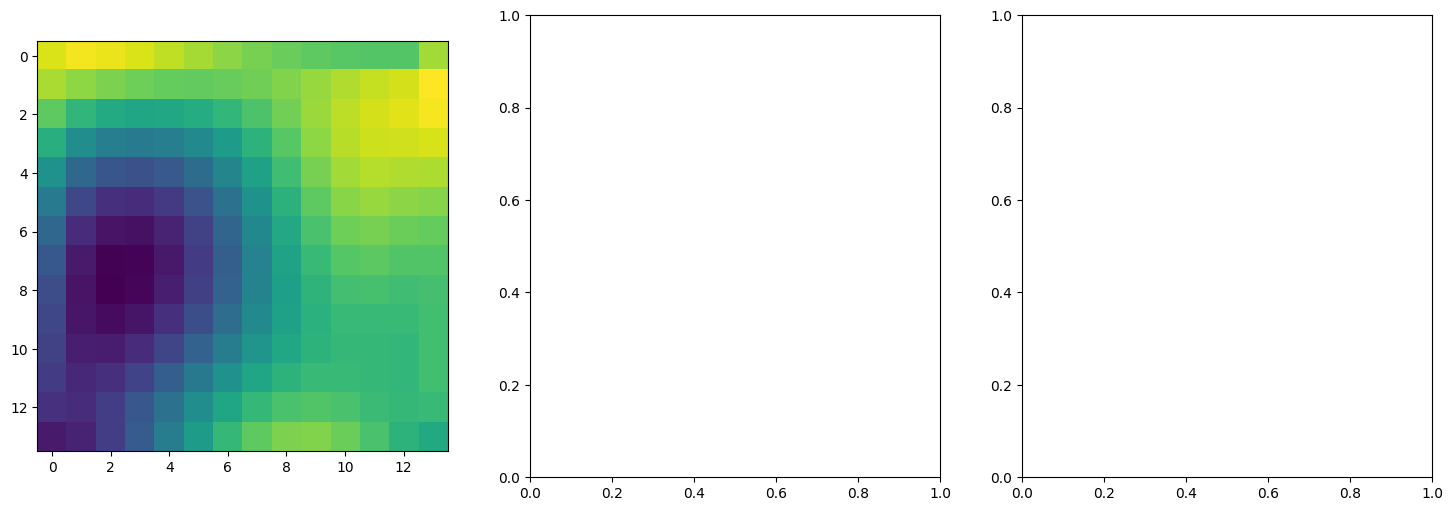

Step 100, Total loss 0.088842


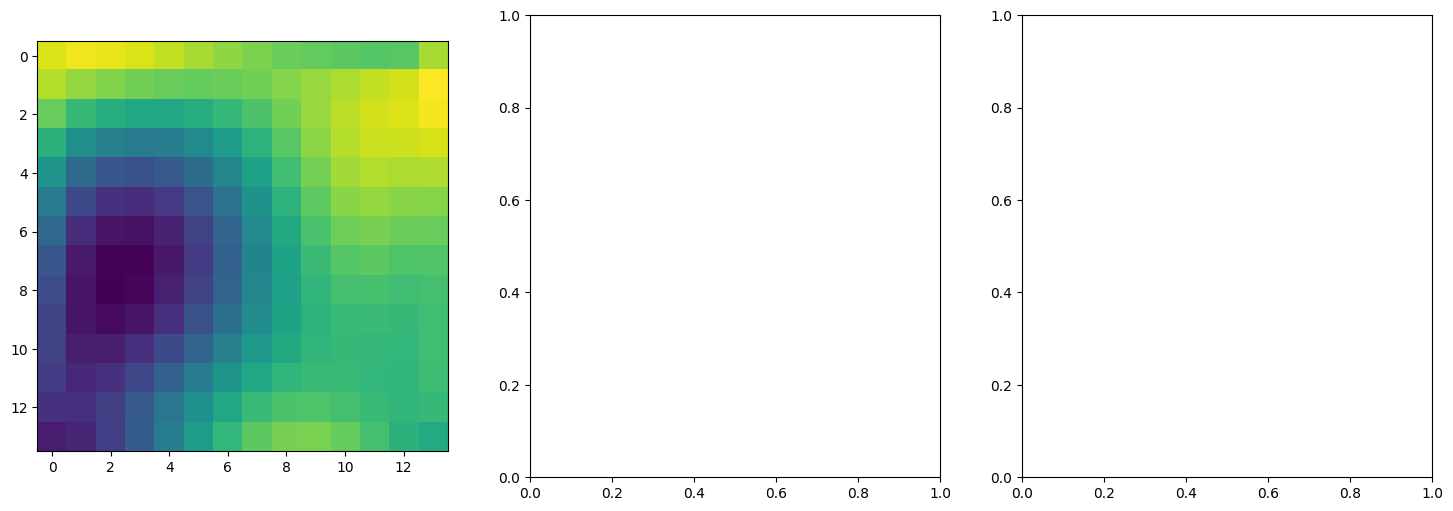

Step 105, Total loss 0.085331


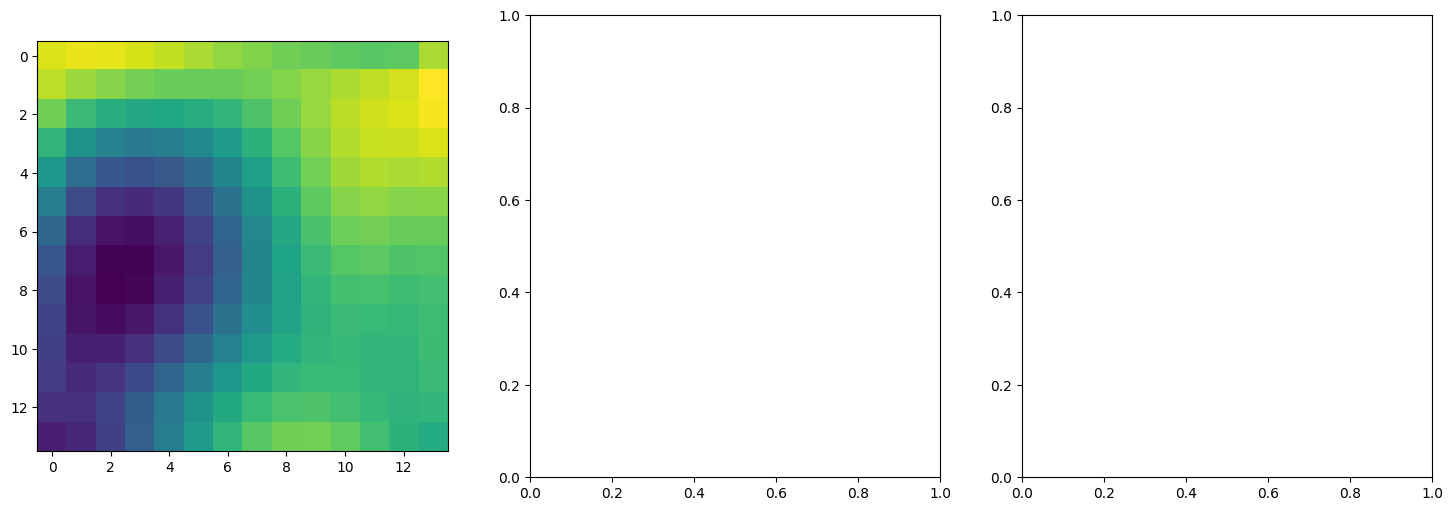

Step 110, Total loss 0.081923


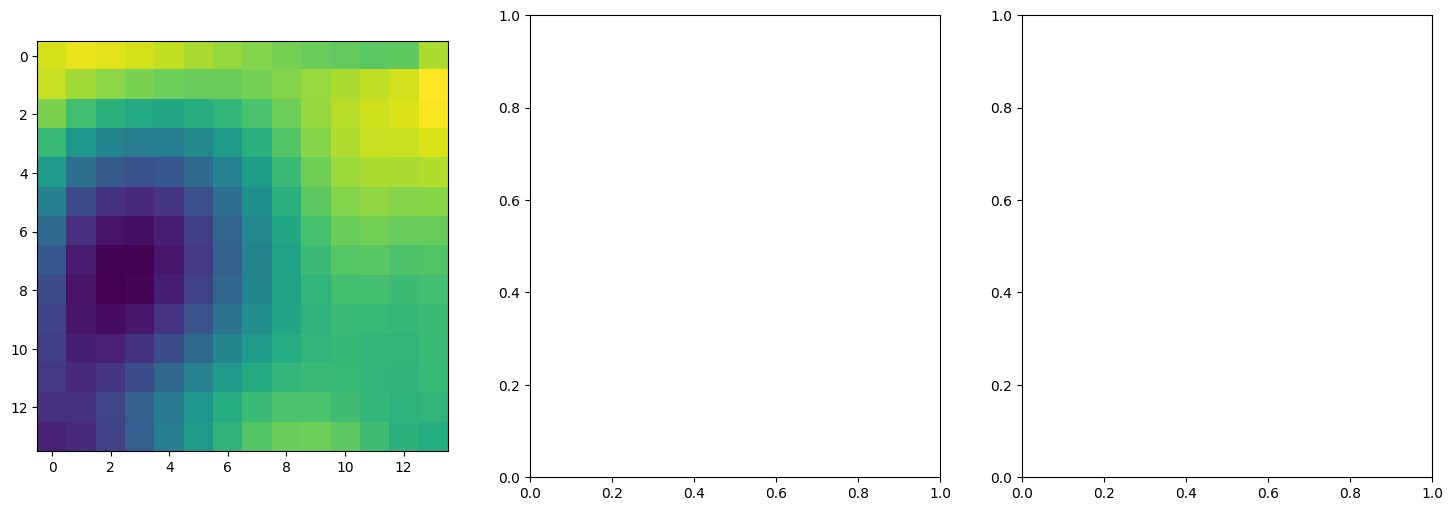

Step 115, Total loss 0.078692


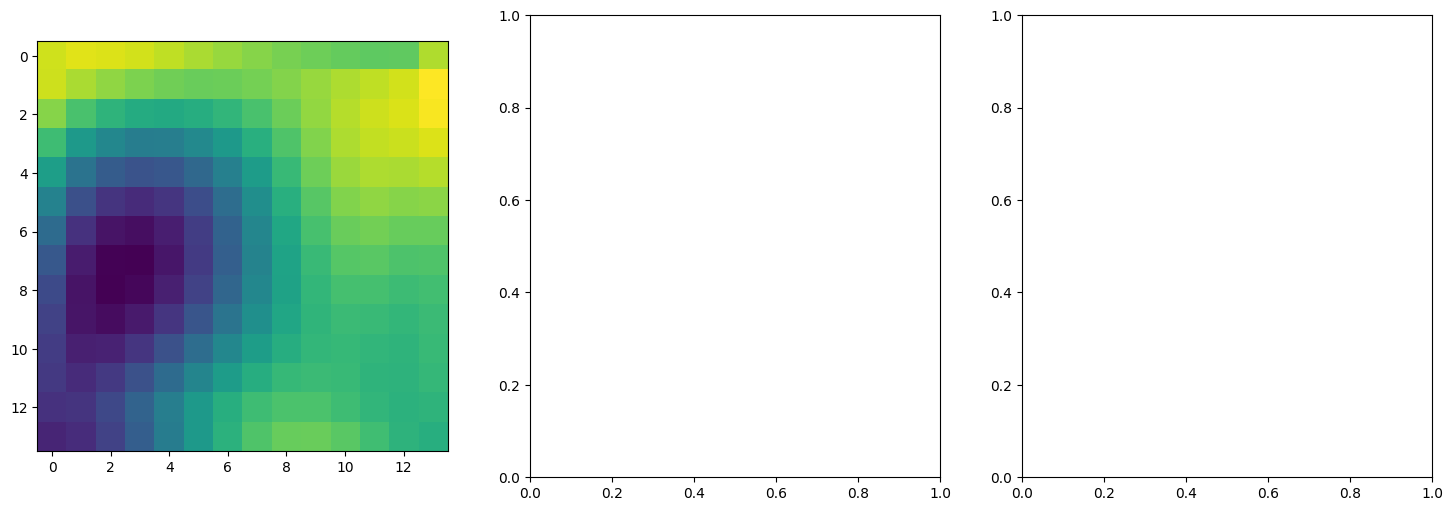

Step 120, Total loss 0.075688


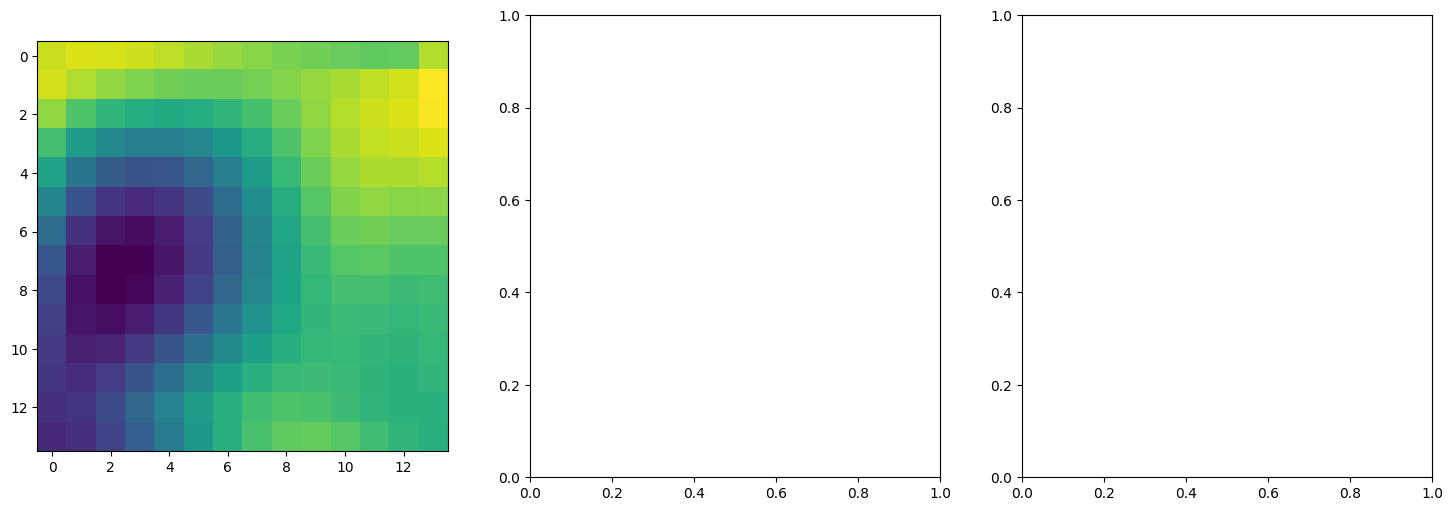

Step 125, Total loss 0.072945


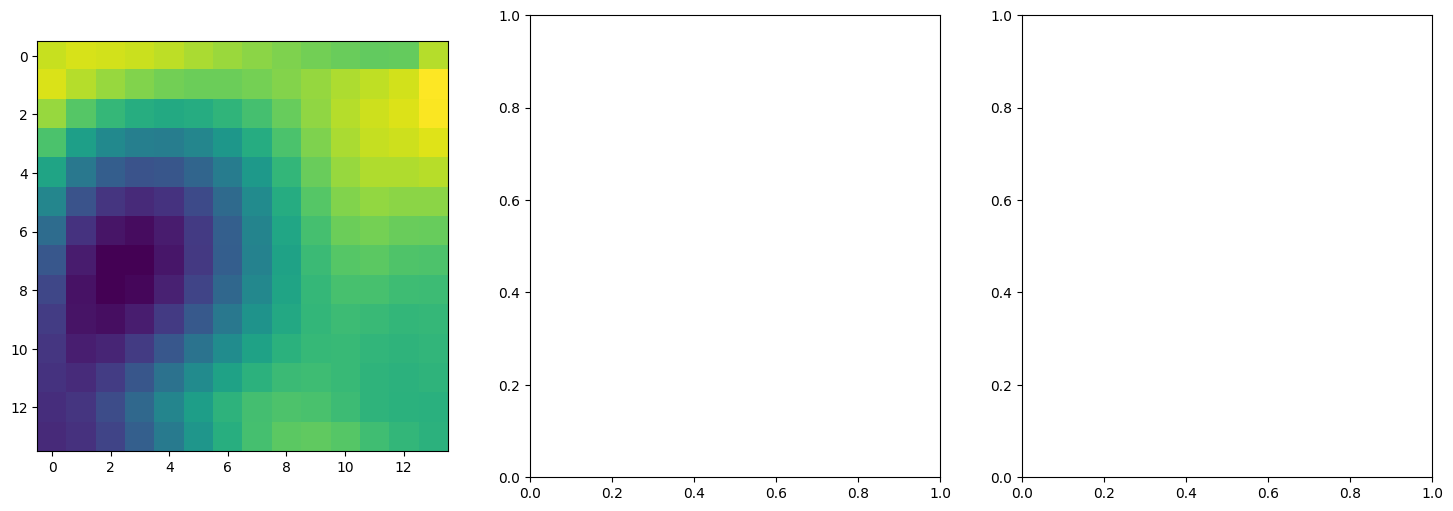

Step 130, Total loss 0.070483


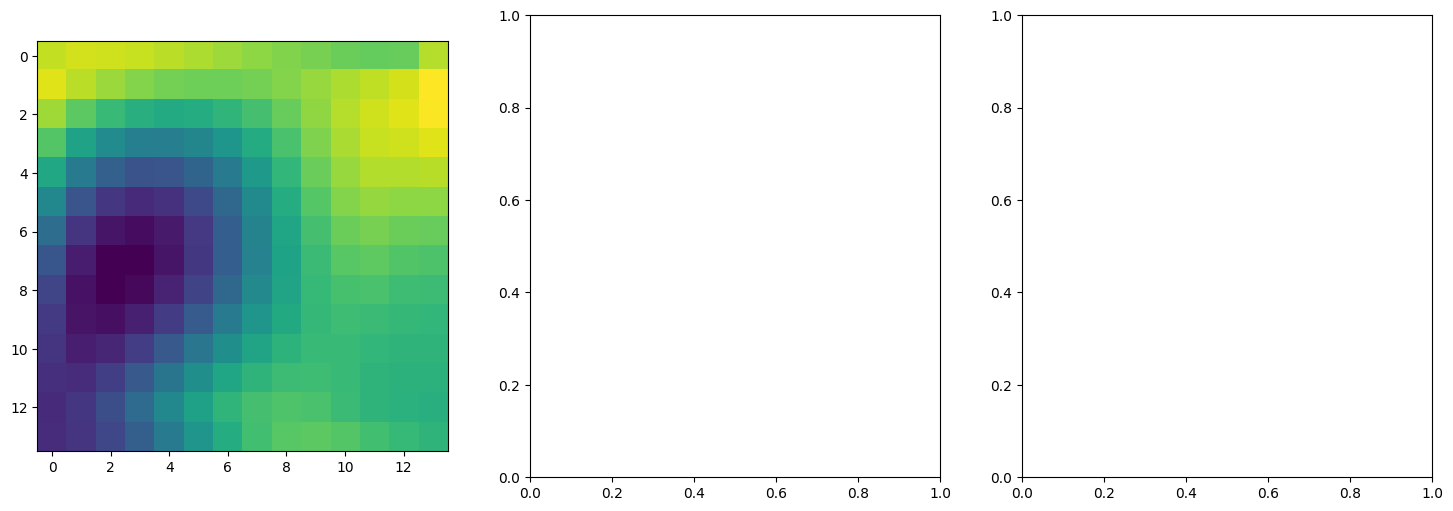

Step 135, Total loss 0.068294


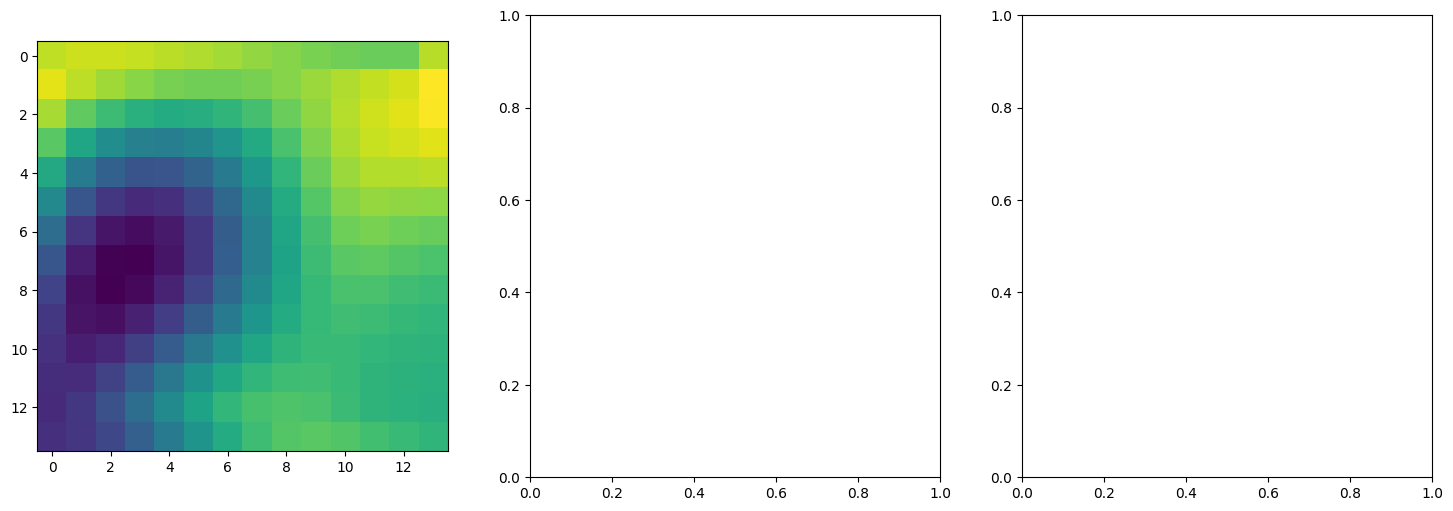

Step 140, Total loss 0.066355


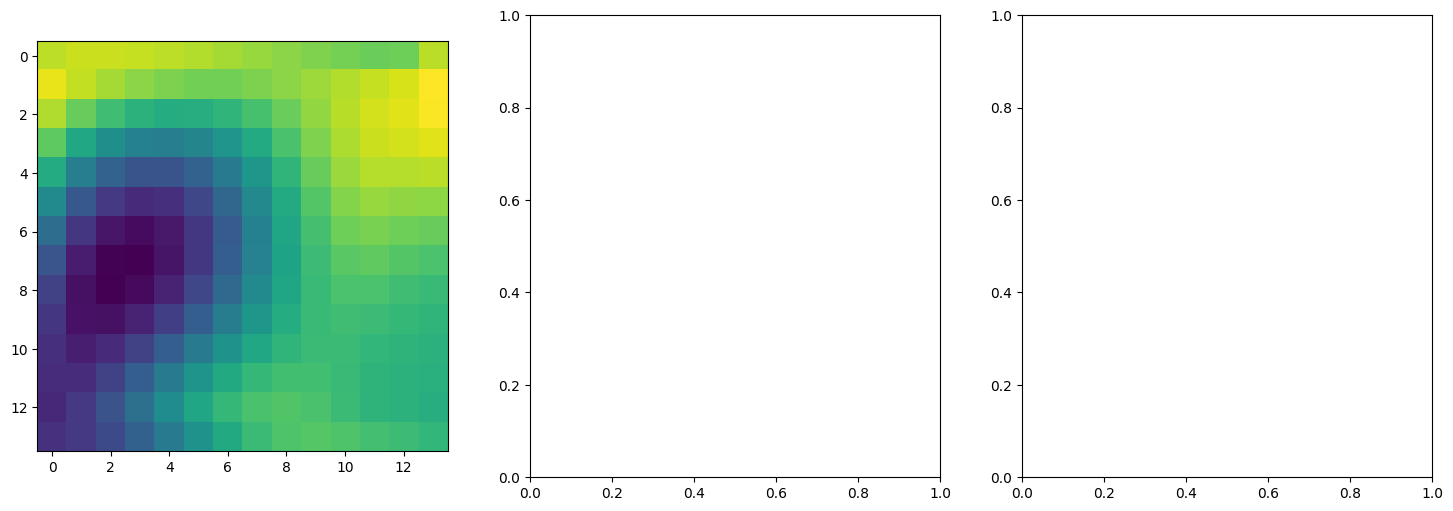

Step 145, Total loss 0.064632


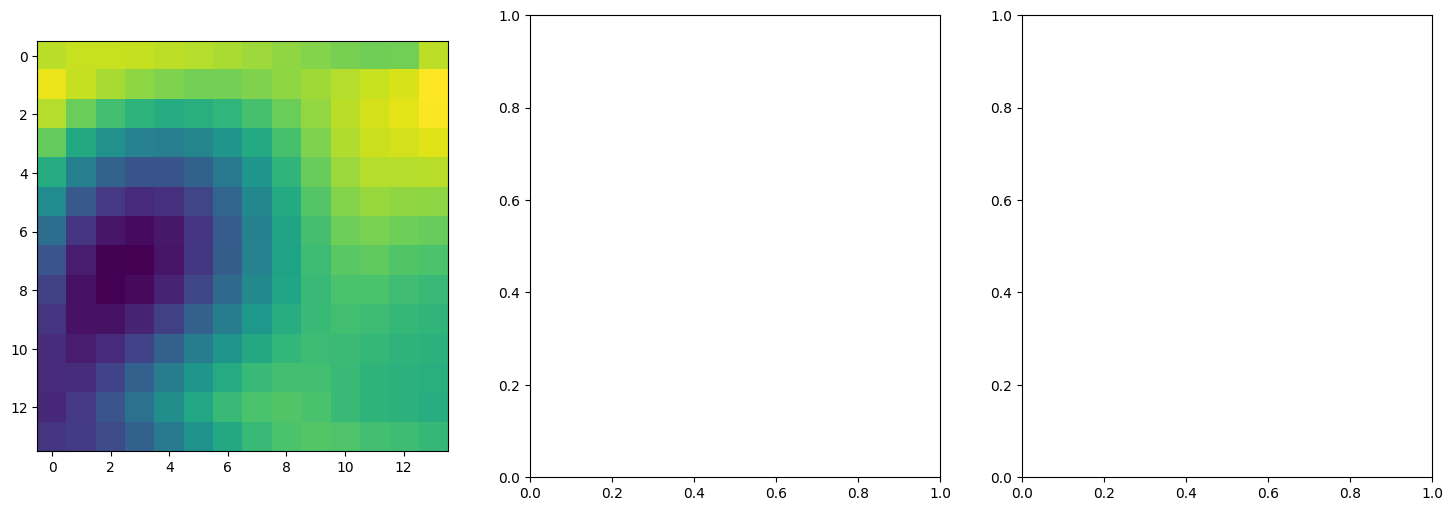

Step 150, Total loss 0.063084


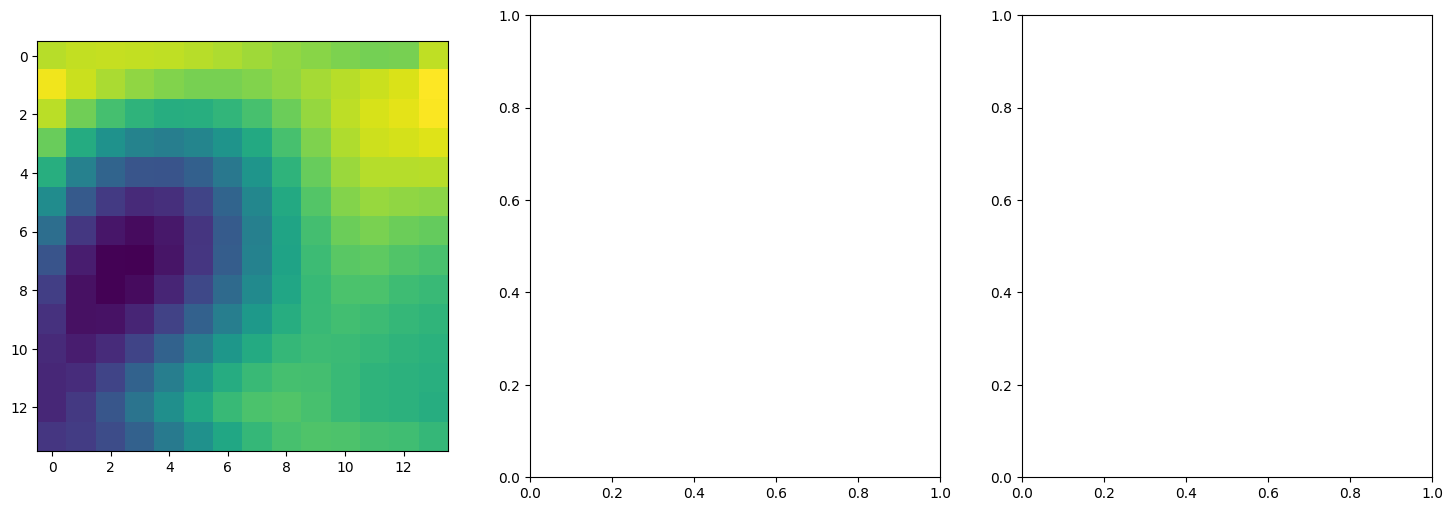

Step 155, Total loss 0.061676


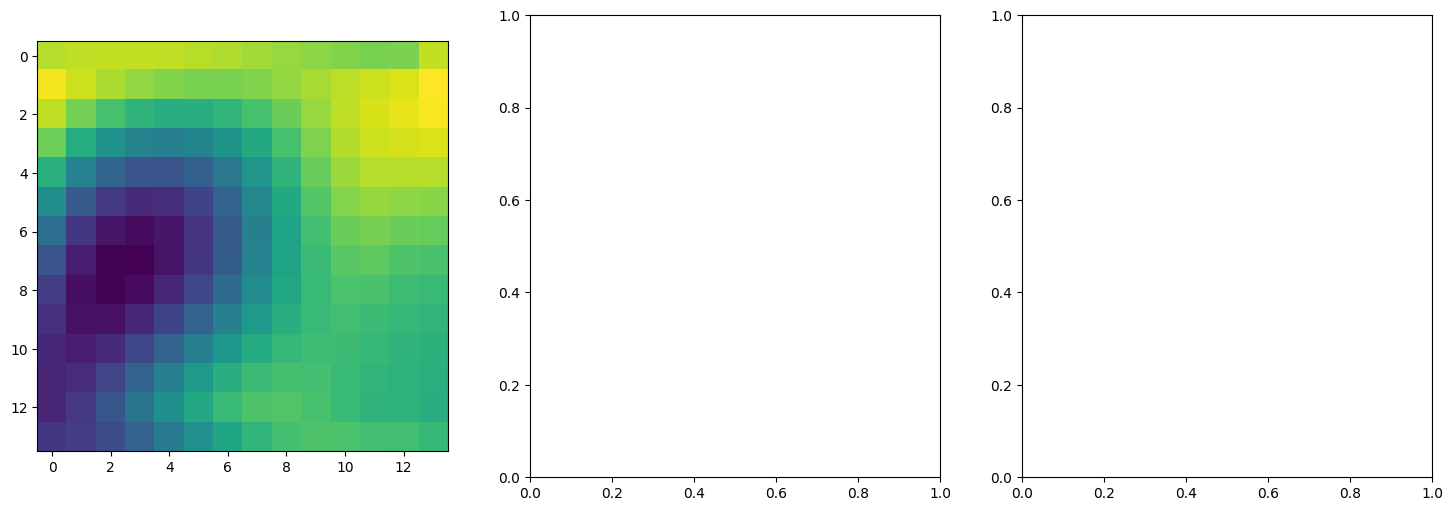

Step 160, Total loss 0.060381


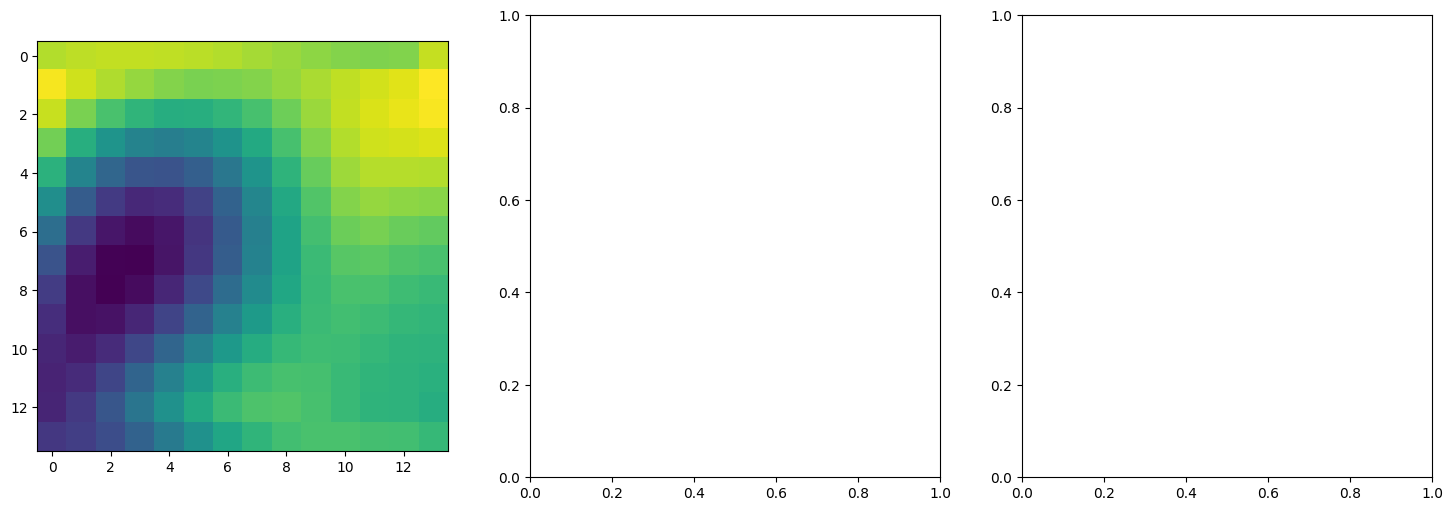

Step 165, Total loss 0.059181


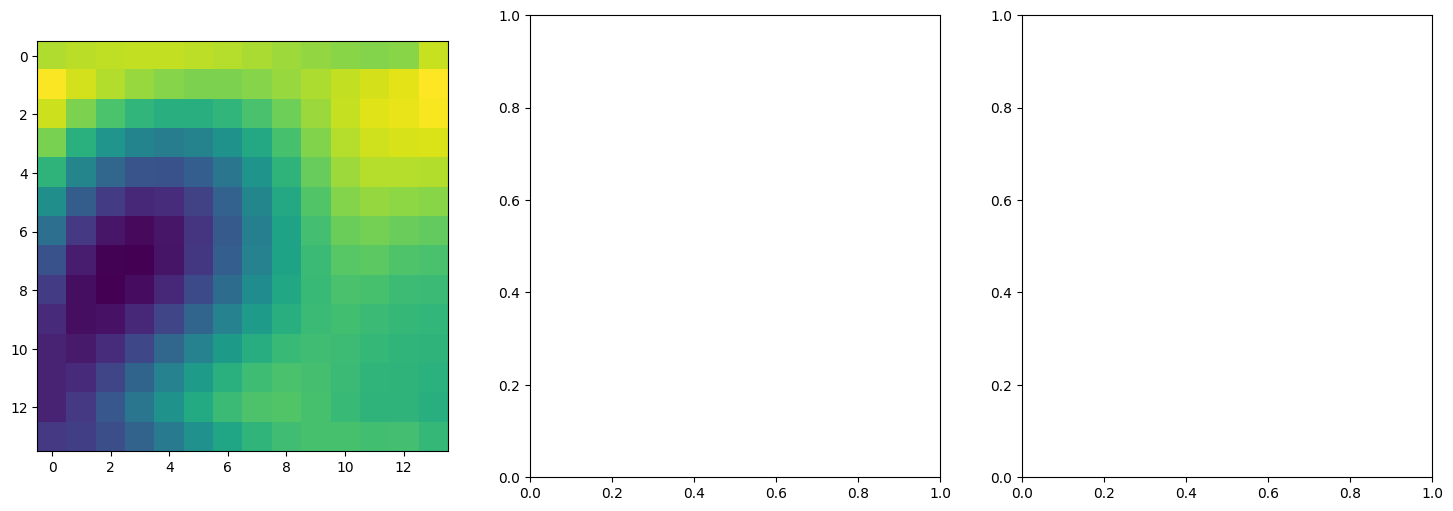

Step 170, Total loss 0.058066


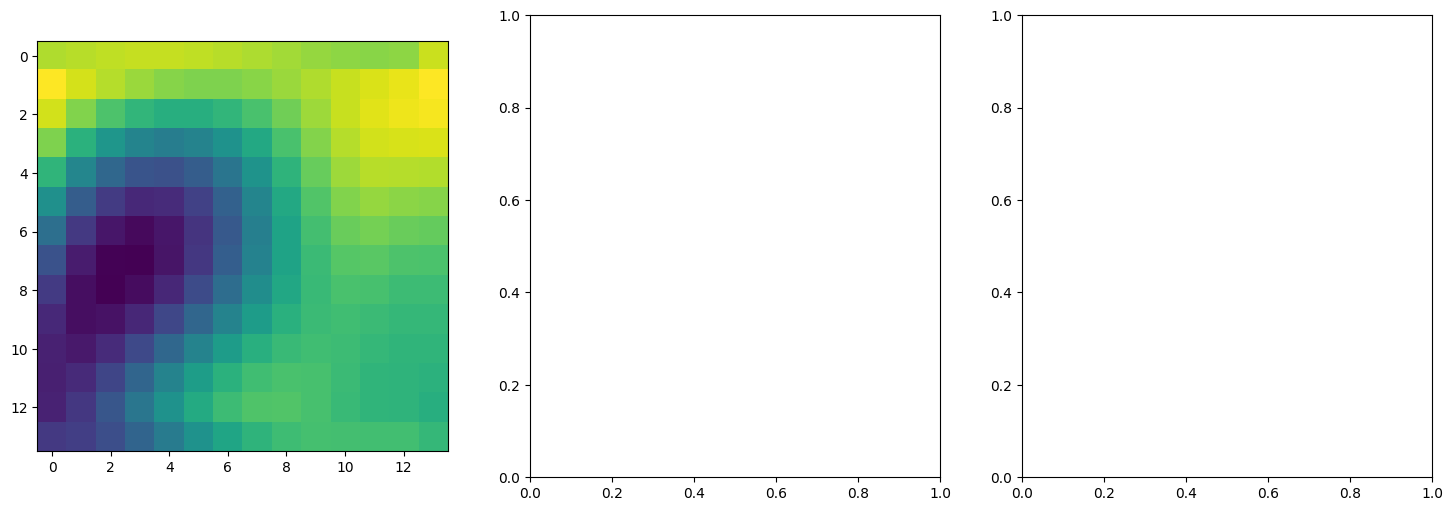

Step 175, Total loss 0.057031


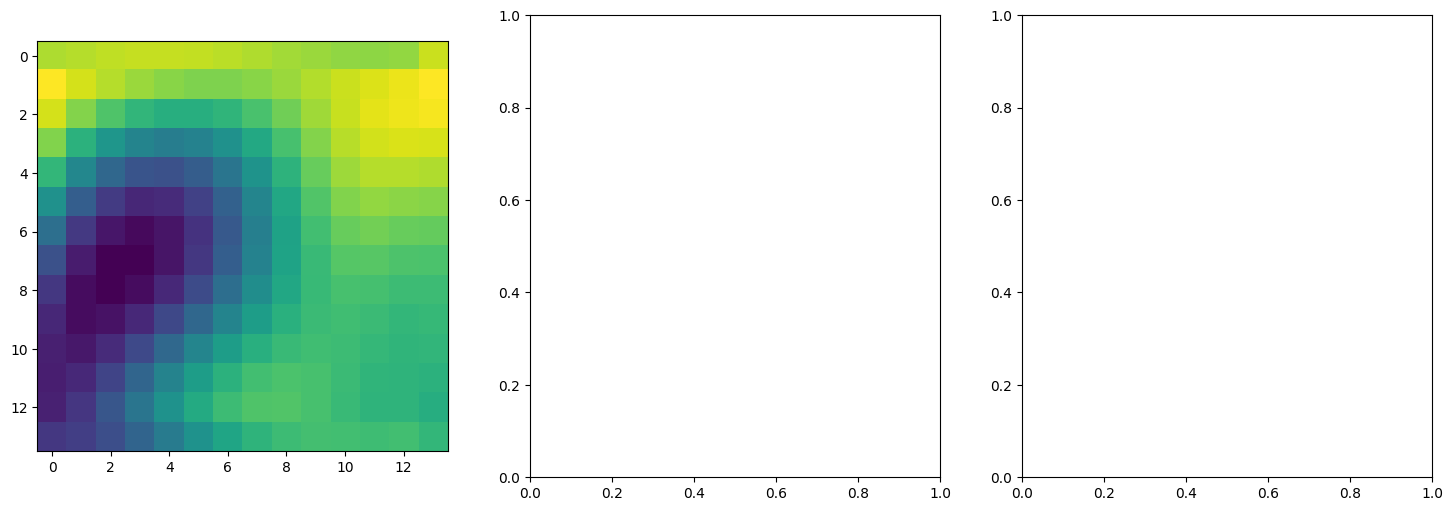

Step 180, Total loss 0.056076


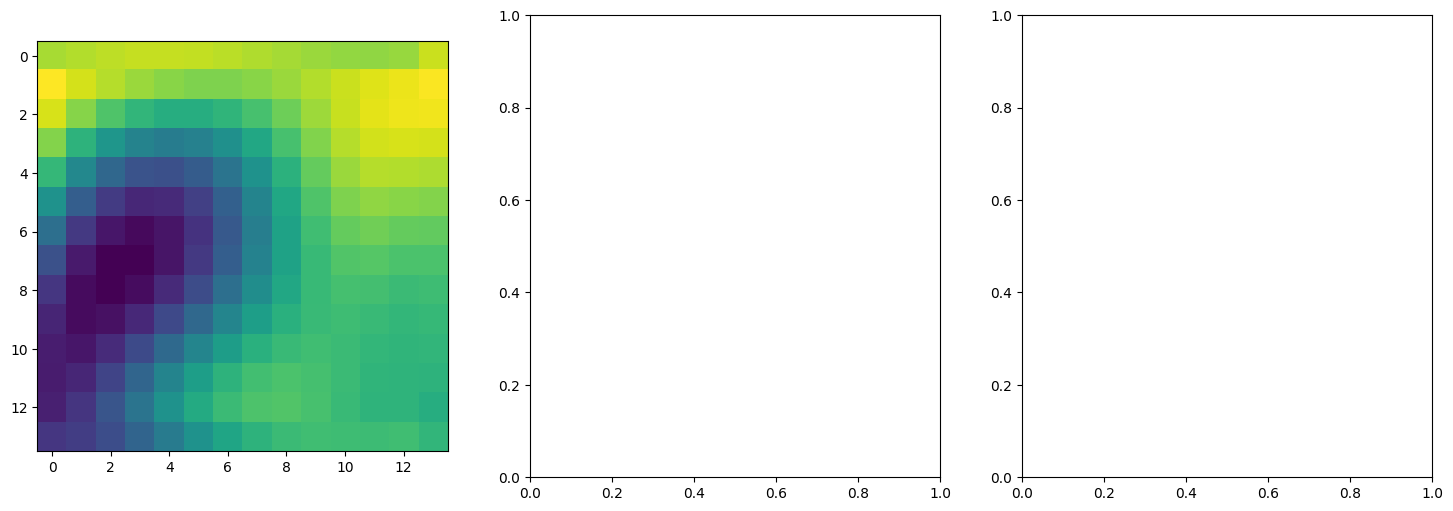

Step 185, Total loss 0.055201


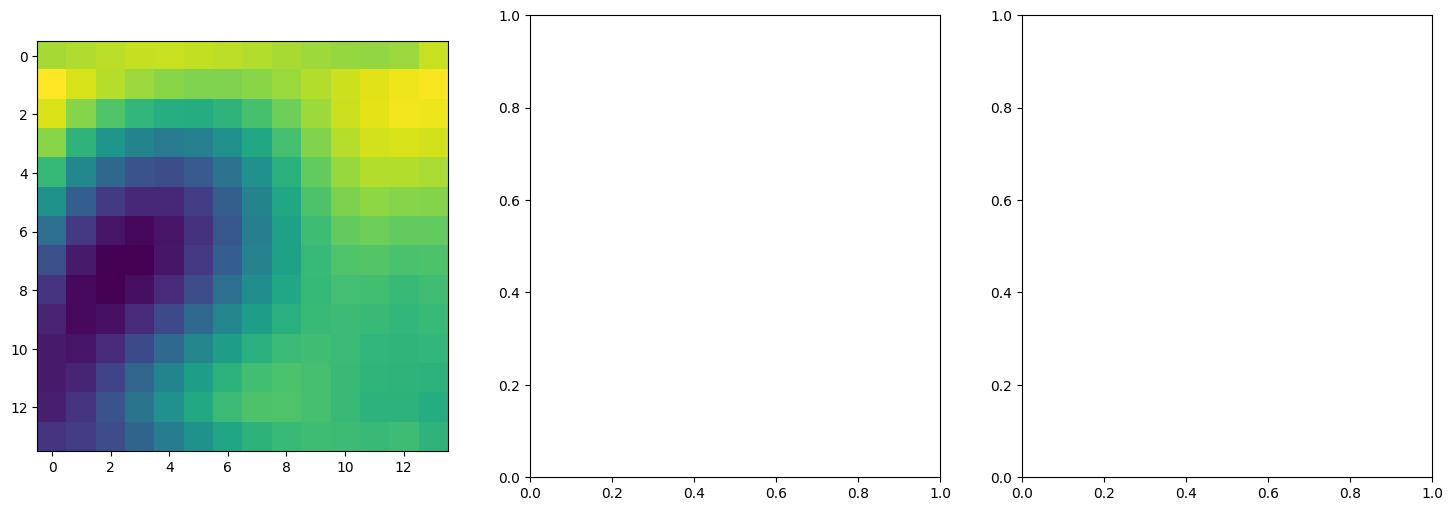

Step 190, Total loss 0.054406


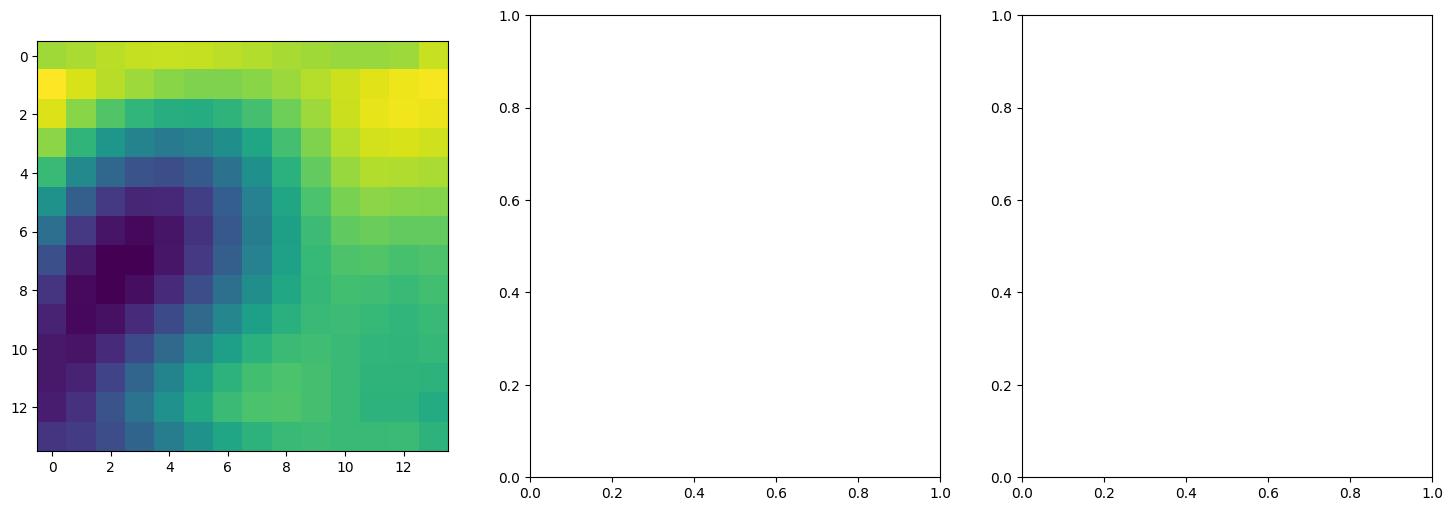

Step 195, Total loss 0.053689


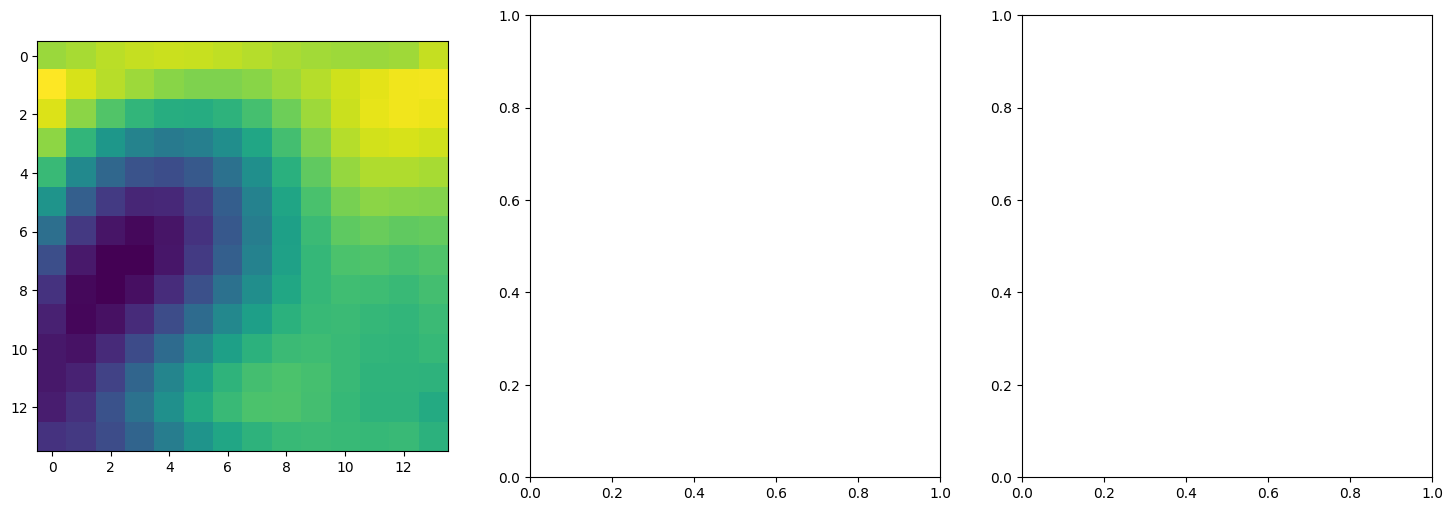

Step 200, Total loss 0.053048


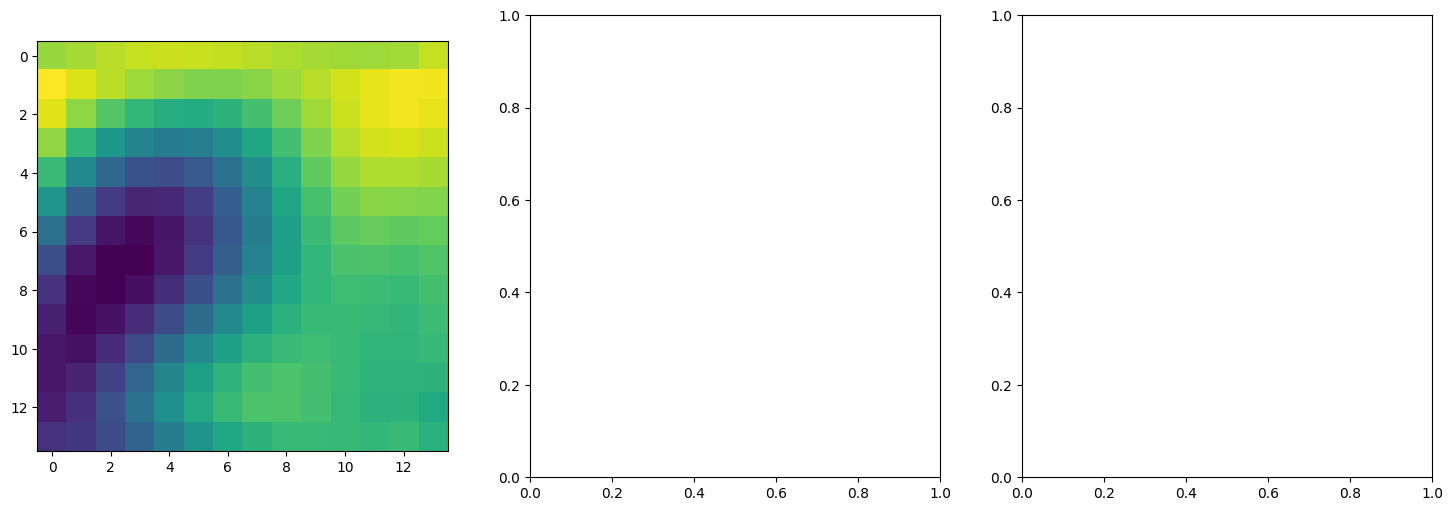

Step 205, Total loss 0.052474


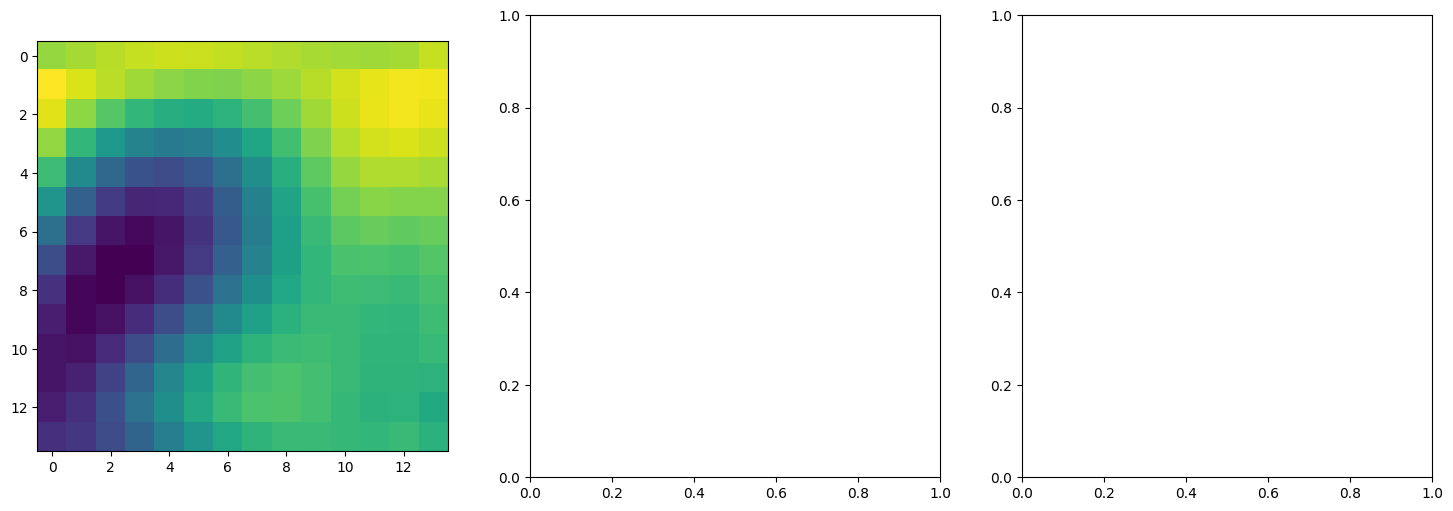

KeyboardInterrupt: 

In [90]:
# params = np.random.uniform(size=(sidelength,sidelength))
params = torch.rand(size=(n_layer,n_qubits,n_gates_per_layer), requires_grad=True) # nLayers, nQubits, nGatesPerLayer

optim = torch.optim.Adam(lr=1e-2, params=[params])

fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(ground_truth.cpu().view(sidelength,sidelength).detach().numpy())
plt.show()

for step in range(total_steps):
    # model_output, coords = img_siren(model_input)

    model_output = cost(model_input[0], params)
    model_output = model_output.reshape((1, model_output.shape[0], 1))
    coords = model_input

    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # print(f"Params: {params}")
        # img_grad = gradient(model_output, coords)
        # img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(sidelength,sidelength).detach().numpy())
        # axes[1].imshow(img_grad.norm(dim=-1).cpu().view(sidelength,sidelength).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(sidelength,sidelength).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()